# MNIST Autoencoder Example

Note: This notebook is desinged to run with Python3 and CPU (no GPU) runtime.

![Python 3 and CPU runtime](https://raw.githubusercontent.com/enakai00/colab_tfbook/master/docs/imgs/runtime_cpu.png)

####[MAE-01]
Import modules and set a random seed.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers, models
from keras.datasets import mnist

Using TensorFlow backend.


####[MAE-02]
Download the MNIST dataset and store into NumPy arrays.

In [0]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape(
                  (len(train_images), 784)).astype('float32') / 255
test_images = test_images.reshape(
                  (len(test_images), 784)).astype('float32') / 255
train_labels = keras.utils.to_categorical(train_labels, 10)
test_labels = keras.utils.to_categorical(test_labels, 10)

####[MAE-03]
Define an autoencoder model for MNIST images.

In [3]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(28*28,)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(784, activation='sigmoid'))

model.summary()

W0613 23:49:36.533032 140002124334976 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0613 23:49:36.553612 140002124334976 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0613 23:49:36.556662 140002124334976 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 16)                2064      
_________________________________________________________________
dense_4 (Dense)              (None, 128)               2176      
_________________________________________________________________
dense_5 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_6 (Dense)              (None, 784)               201488    
Total params: 472,608
Trainable params: 472,608
Non-trainable params: 0
_________________________________________________________________


####[MAE-04]
Compile the model using the Adam optimizer, and MSE as a loss function.

In [4]:
model.compile(optimizer='adam', loss='mse')

W0613 23:49:40.179906 140002124334976 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



####[MAE-05]
Define a function to show reconstructed images.

In [0]:
def show_result():
    results = model.predict(test_images[:8])
  
    fig = plt.figure(figsize=(16, 2.7))
    for i in range(8):
      subplot = fig.add_subplot(2, 10, i+1)
      subplot.set_xticks([])
      subplot.set_yticks([])
      subplot.imshow(test_images[i].reshape((28, 28)),
                     vmin=0, vmax=1, cmap=plt.cm.gray_r)

      subplot = fig.add_subplot(2, 10, i+11)
      subplot.set_xticks([])
      subplot.set_yticks([])
      subplot.imshow(results[i].reshape((28, 28)),
                     vmin=0, vmax=1, cmap=plt.cm.gray_r)

####[MAE-06]
Train the model for a single epoch with 30,000 images, and show the intermediate result.

W0613 23:49:47.952738 140002124334976 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0613 23:49:48.098685 140002124334976 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Epoch 1/1
30000/30000 [==============================] - 2s 66us/step - loss: 0.0800


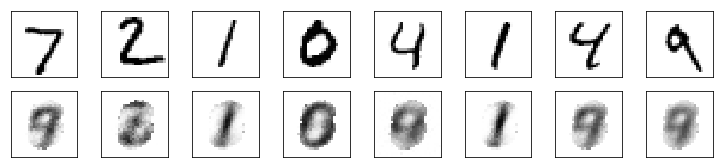

In [6]:
history = model.fit(train_images[:30000], train_images[:30000],
                    batch_size=256, epochs=1)
show_result()

####[MAE-07]
Train the model for additional epochs, and show the final result.

Epoch 1/6
60000/60000 [==============================] - 1s 19us/step - loss: 0.0395
Epoch 2/6
60000/60000 [==============================] - 1s 19us/step - loss: 0.0271
Epoch 3/6
60000/60000 [==============================] - 1s 19us/step - loss: 0.0229
Epoch 4/6
60000/60000 [==============================] - 1s 19us/step - loss: 0.0208
Epoch 5/6
60000/60000 [==============================] - 1s 19us/step - loss: 0.0196
Epoch 6/6
60000/60000 [==============================] - 1s 19us/step - loss: 0.0187


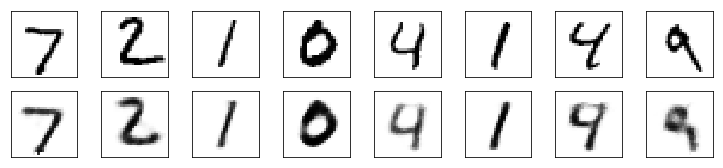

In [7]:
history = model.fit(train_images, train_images,
                    batch_size=256, epochs=6)
show_result()

####[MAE-08]
Define a Javascript function to create a drawing canvas.

In [0]:
input_form = """
<table>
<td style="border-style: none;">
<div style="border: solid 2px #666; width: 143px; height: 144px;">
<canvas width="140" height="140"></canvas>
</div></td>
<td style="border-style: none;">
<button onclick="clear_value()">Clear</button>
</td>
</table>
"""

javascript = """
<script type="text/Javascript">
    var pixels = [];
    for (var i = 0; i < 28*28; i++) pixels[i] = 0;
    var click = 0;

    var canvas = document.querySelector("canvas");
    canvas.addEventListener("mousemove", function(e) {
        if (e.buttons == 1) {
            click = 1;
            canvas.getContext("2d").fillStyle = "rgb(0, 0, 0)";
            canvas.getContext("2d").fillRect(e.offsetX, e.offsetY, 8, 8);
            x = Math.floor(e.offsetY*0.2);
            y = Math.floor(e.offsetX*0.2) + 1;
            for (var dy = 0; dy < 2; dy++) {
                for (var dx = 0; dx < 2; dx++) {
                    if ((x + dx < 28) && (y + dy < 28)) {
                        pixels[(y+dy)+(x+dx)*28] = 1;
                    }
                }
            }
        } else {
            if (click == 1) set_value()
            click = 0;
        }
    });
    
    function set_value() {
        var result = "";
        for (var i = 0; i < 28*28; i++) result += pixels[i] + ",";
        google.colab.kernel.invokeFunction(
                          'notebook.set_image', [result], {});
    }
    
    function clear_value() {
        canvas.getContext("2d").fillStyle = "rgb(255, 255, 255)";
        canvas.getContext("2d").fillRect(0, 0, 140, 140);
        for (var i = 0; i < 28*28; i++) pixels[i] = 0;
    }
</script>
"""

####[MAE-09]
Show a drawing canvas.

In [9]:
from google.colab import output  
from IPython.display import HTML

def set_image(result):
    global image
    image = np.array([float(x) for x in result.split(',')[:-1]])

image = None
output.register_callback('notebook.set_image', set_image)

HTML(input_form + javascript)

####[MAE-10]
Show a resconstructed image from the handwritten example.

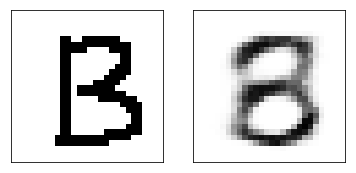

In [12]:
results = model.predict(np.array([image]))

fig = plt.figure(figsize=(6, 3))
subplot = fig.add_subplot(1, 2, 1)
subplot.set_xticks([])
subplot.set_yticks([])
subplot.imshow(np.array(image).reshape((28, 28)), 
               vmin=0, vmax=1, cmap=plt.cm.gray_r)
subplot = fig.add_subplot(1, 2, 2)
subplot.set_xticks([])
subplot.set_yticks([])
subplot.imshow(results[0].reshape((28, 28)),
               vmin=0, vmax=1, cmap=plt.cm.gray_r)